In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
bright_features = pd.read_csv('massive_features.csv')
bright_features.drop(columns=['Unnamed: 0'],inplace=True)
bright_sample = pd.read_csv('../data/bright_sample/massive.csv.gz')

In [3]:
timeout_names = np.setdiff1d(bright_sample['original_ext_source_id'].values,bright_features['Name'].values)
len(timeout_names)

6

In [4]:
bright = pd.merge(bright_sample,bright_features,left_on='original_ext_source_id',right_on='Name')
len(bright)

2494

In [5]:
def plot_3_plots(df, col=None, cfunc=None, clim=None, points='scatter', *args, **kwargs):
    """
    Plot 2 CMDs side-by-side: first Gaia then WISE. Then plot the color-color plot
    
    Parameters
    ----------
    df : `~pandas.DataFrame`
        Contains all the columns you need to generate CMDs
    col : str
        Column to color points by, default behavior is to just plot density if points='hexbin'
    cfunc : function
        If not None, will apply the given function to the color array. E.g., abs, np.reciprocal, etc.
    clim : array-like
        Array-like of length 2. If given, sets the colorbar limits
    points : str
        If points='scatter', calls plt.scatter. If points='hexbin', calls plt.hexbin
    *args, **kwargs
        Passed to the plotting function
        
    Returns
    _______
    fig, optax, irax, colax
        Pyplot figure and axes objects
    """
    
    assert points in ['scatter','hexbin'], 'Please use points="scatter" or "hexbin"'
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    
    optax = axes[0]
    irax = axes[1]
    colax = axes[2]
    
    opt_color = df['(BP_RP)_0']
    opt_mag = df['M_G']
    
    optax.set(xlabel=r'$G_{BP}-G_{RP}$',ylabel='$M_G$')
    
    ir_color = df['W1-W2']
    ir_mag = df['w1mpro'] + 5 * np.log10(df['parallax']) - 10
    
    irax.set(xlabel=r'$W1-W2$',ylabel=r'$M_{W1}$')
    
    colax.set(xlabel=r'$G_{BP}-G_{RP}$', ylabel=r'$W1-W2$')
    
    if col is not None:
        if cfunc is not None:
            color = cfunc(df[col])
            clab = '{0} ${1}$'.format(cfunc.__name__,col)
        else:
            color = df[col]
            clab = '${0}$'.format(col)
    
    if points=='scatter':
        if col is not None:
            opt_obj = optax.scatter(opt_color,opt_mag,c=color,*args,**kwargs)
            ir_obj = irax.scatter(ir_color,ir_mag,c=color,*args,**kwargs)
            col_obj = colax.scatter(opt_color, ir_color, c=color, *args, **kwargs)
        else:
            optax.scatter(opt_color,opt_mag,*args,**kwargs)
            irax.scatter(ir_color,ir_mag,*args,**kwargs)
            col_obj = colax.scatter(opt_color, ir_color, *args, **kwargs)
            
    elif points=='hexbin':
        if col is not None:
            opt_obj = optax.hexbin(opt_color,opt_mag,C=color,*args,**kwargs)
            ir_obj = irax.hexbin(ir_color,ir_mag,C=color,*args,**kwargs)
            col_obj = colax.hexbin(opt_color,ir_color,C=color,*args,**kwargs)
        else:
            opt_obj = optax.hexbin(opt_color,opt_mag,*args,**kwargs)
            ir_obj = irax.hexbin(ir_color,ir_mag,*args,**kwargs)
            col_obj = colax.hexbin(opt_color,ir_color,*args,**kwargs)
    
    for ax in axes[:2]:
        ax.invert_yaxis()
        
    fig.tight_layout()
    
    if col is not None:
    
        cbar = plt.colorbar(col_obj,ax=[optax,irax,colax],label=clab)
        if clim is not None:
            opt_obj.set_clim(*clim)
            ir_obj.set_clim(*clim)
            col_obj.set_clim(*clim)
        
    elif points=='hexbin':
        
        cbar = plt.colorbar(col_obj,ax=[optax,irax,colax],label='N')
        if clim is not None:
            opt_obj.set_clim(*clim)
            ir_obj.set_clim(*clim)
            col_obj.set_clim(*clim)
            
    return fig,optax,irax,colax,cbar

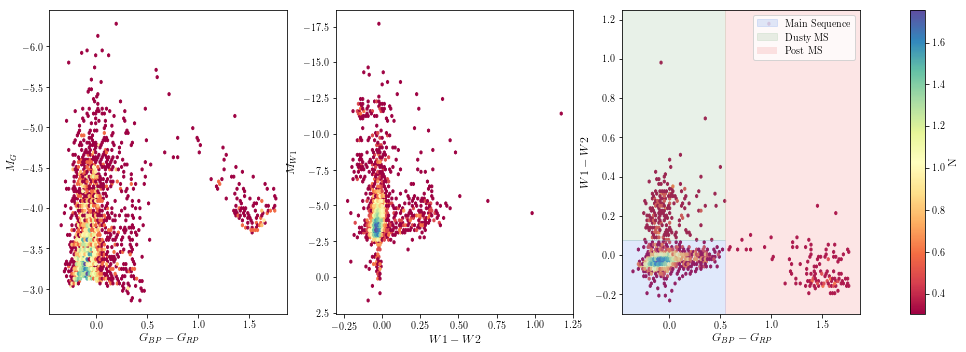

In [28]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, points='hexbin', mincnt=1, bins='log', cmap='Spectral')
colax_xlim = colax.get_xlim()
colax_ylim = colax.get_ylim()
colax.fill([colax_xlim[0],0.55,0.55,colax_xlim[0]],[colax_ylim[0],colax_ylim[0],0.075,0.075],
           alpha=0.2,c='cornflowerblue',label='Main Sequence')
colax.fill([colax_xlim[0],0.55,0.55,colax_xlim[0]],[0.075,0.075,colax_ylim[1],colax_ylim[1]],
           alpha=0.2,c='darkseagreen',label='Dusty MS')
colax.axvspan(xmin=0.55,xmax=colax_xlim[1],facecolor='lightcoral',
              alpha=0.2,label='Post MS')
colax.fill([0.55,colax_xlim[1],colax_xlim[1],0.55],[colax_ylim[0],colax_ylim[0],colax_ylim[1],colax_ylim[1]],
           alpha=0.3,c='lightcoral',label='Dusty MS')
colax.set(xlim=colax_xlim,ylim=colax_ylim)
h,l = colax.get_legend_handles_labels()
colax.legend(h[:3], l[:3])

In [51]:
mainsequence = bright[(bright['(BP_RP)_0']<=0.55)&(bright['W1-W2']<=0.075)]
dustyms = bright[(bright['(BP_RP)_0']<=0.55)&(bright['W1-W2']>0.075)]
postms = bright[(bright['(BP_RP)_0']>0.55)]

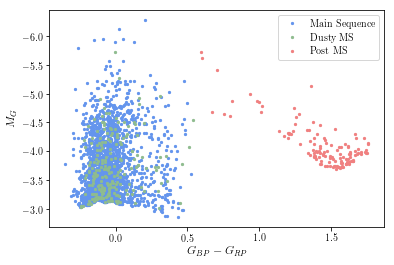

In [54]:
plt.scatter(mainsequence['(BP_RP)_0'],mainsequence['M_G'],s=5,
            c='cornflowerblue',label='Main Sequence')
plt.scatter(dustyms['(BP_RP)_0'],dustyms['M_G'],s=5,
            c='darkseagreen',label='Dusty MS')
plt.scatter(postms['(BP_RP)_0'],postms['M_G'],s=5,
            c='lightcoral',label='Post MS')
plt.gca().invert_yaxis()
plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$M_G$')
plt.legend()

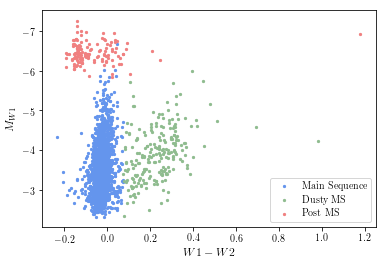

In [56]:
plt.scatter(mainsequence['W1-W2'],mainsequence['M_W1'],s=5,
            c='cornflowerblue',label='Main Sequence')
plt.scatter(dustyms['W1-W2'],dustyms['M_W1'],s=5,
            c='darkseagreen',label='Dusty MS')
plt.scatter(postms['W1-W2'],postms['M_W1'],s=5,
            c='lightcoral',label='Post MS')
plt.gca().invert_yaxis()
plt.xlabel(r'$W1-W2$')
plt.ylabel(r'$M_{W1}$')
plt.legend()

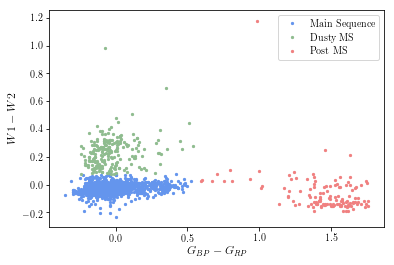

In [58]:
plt.scatter(mainsequence['(BP_RP)_0'],mainsequence['W1-W2'],s=5,
            c='cornflowerblue',label='Main Sequence')
plt.scatter(dustyms['(BP_RP)_0'],dustyms['W1-W2'],s=5,
            c='darkseagreen',label='Dusty MS')
plt.scatter(postms['(BP_RP)_0'],postms['W1-W2'],s=5,
            c='lightcoral',label='Post MS')
plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$W1-W2$')
plt.legend()

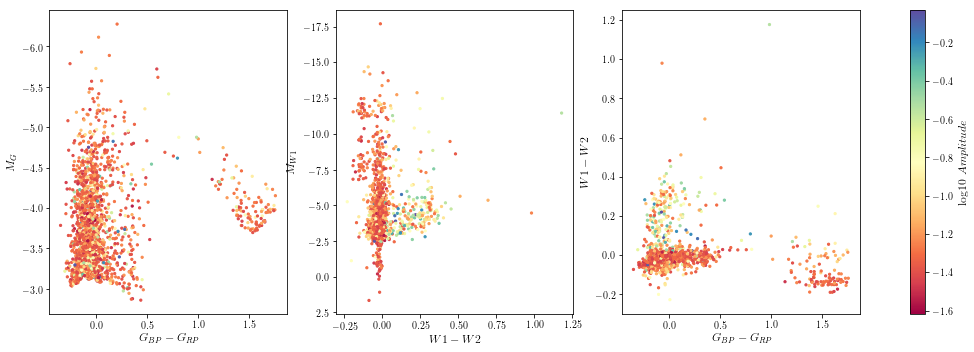

In [29]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='Amplitude', cfunc=np.log10, points='scatter', s=5, cmap='Spectral')

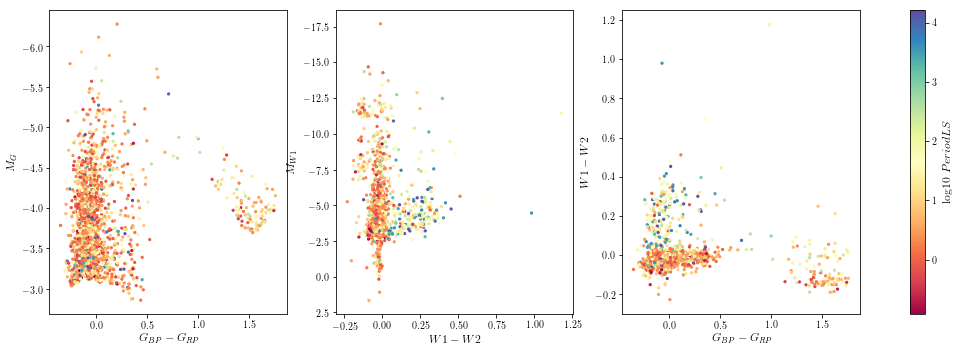

In [30]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='PeriodLS', cfunc=np.log10, points='scatter', s=5, cmap='Spectral')

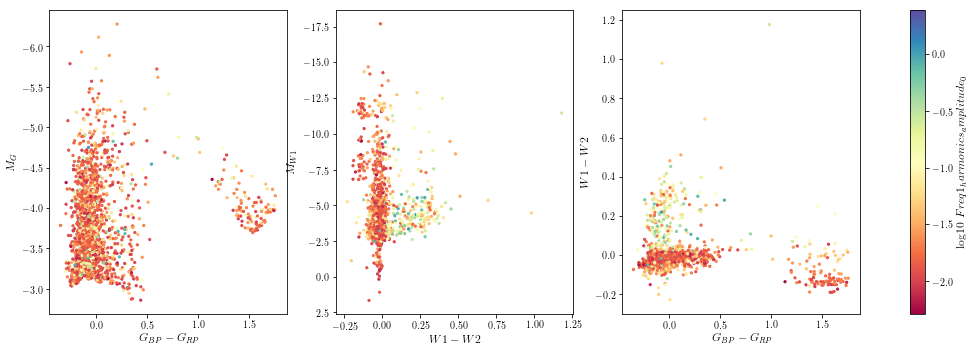

In [31]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='Freq1_harmonics_amplitude_0', cfunc=np.log10, points='scatter', s=5, cmap='Spectral')

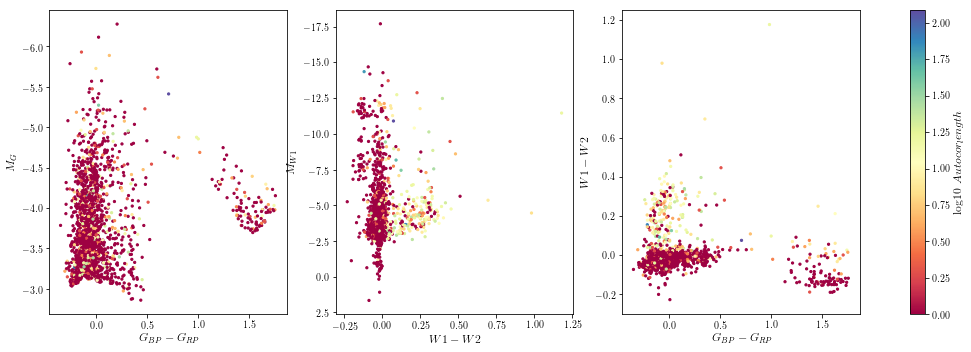

In [32]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='Autocor_length', cfunc=np.log10, points='scatter', s=5, cmap='Spectral')

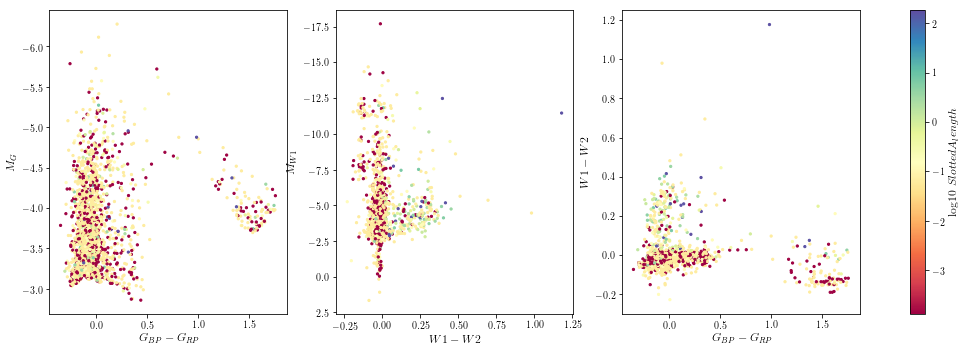

In [33]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='SlottedA_length', cfunc=np.log10, points='scatter', s=5, cmap='Spectral')

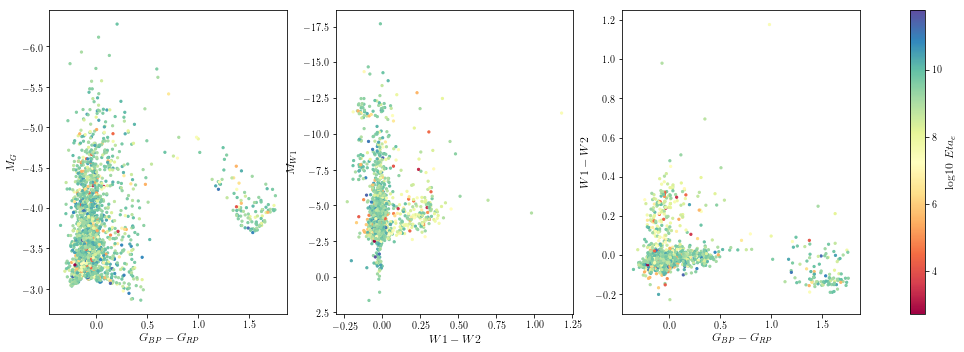

In [34]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='Eta_e', cfunc=np.log10, points='scatter', s=5, cmap='Spectral')

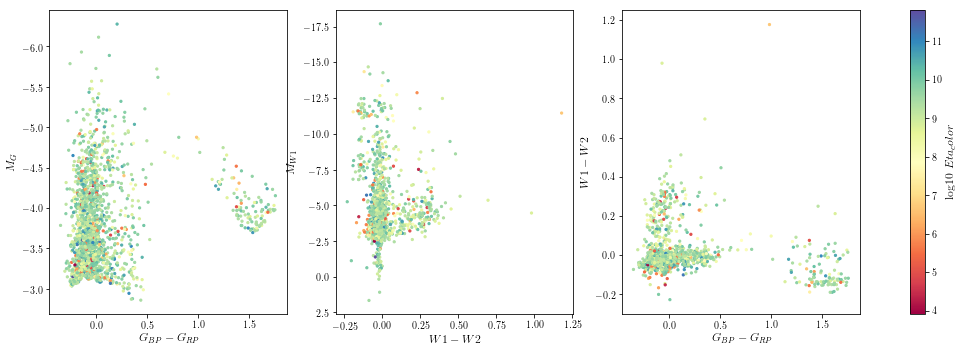

In [35]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='Eta_color', cfunc=np.log10, points='scatter', s=5, cmap='Spectral')

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in log10


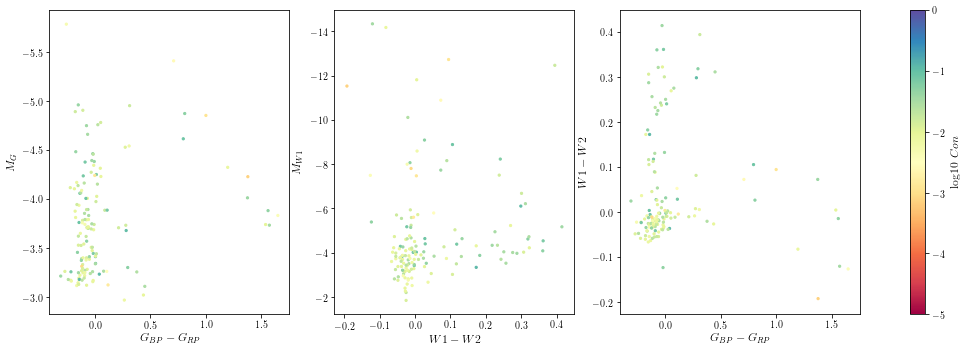

In [49]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='Con', cfunc=np.log10, clim=(-5,0), points='scatter', s=5, cmap='Spectral')

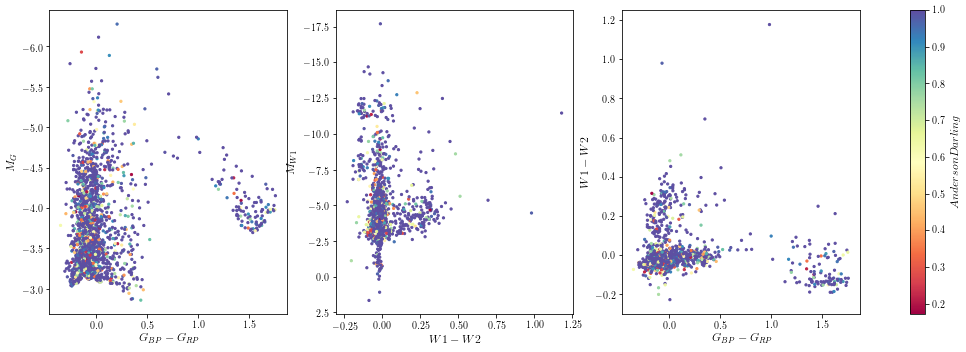

In [59]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='AndersonDarling', points='scatter', s=5, cmap='Spectral')

In [61]:
def log_inv(x):
    __name__ = 'Log Inverse'
    return np.log10(np.reciprocal(x))

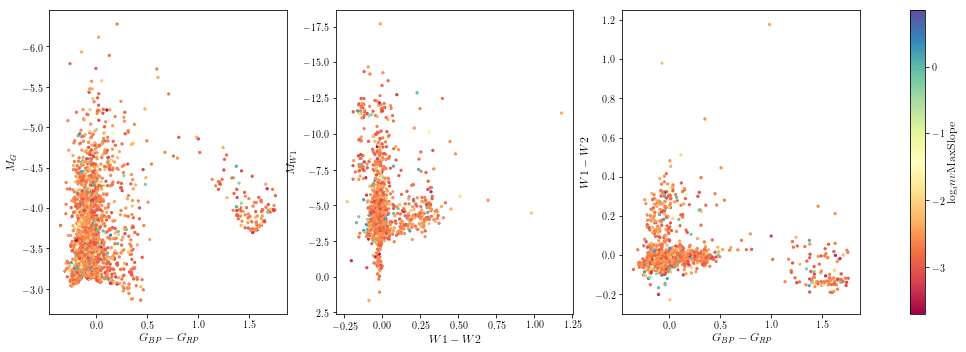

In [62]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='MaxSlope', cfunc=log_inv, points='scatter', s=5, cmap='Spectral')

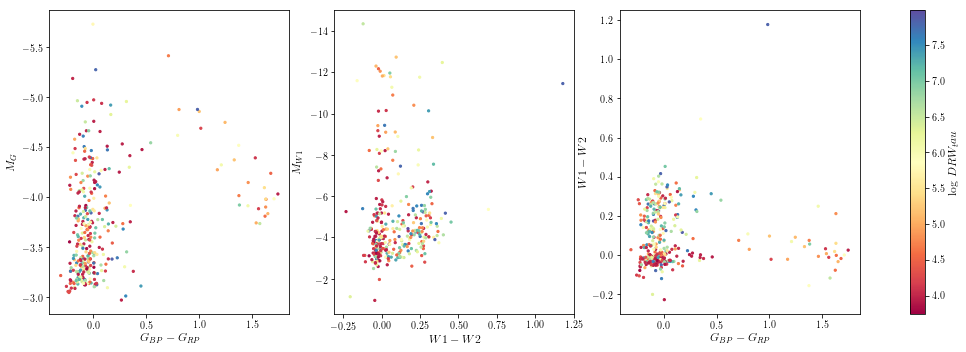

In [63]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='DRW_tau', cfunc=np.log, points='scatter', s=5, cmap='Spectral')

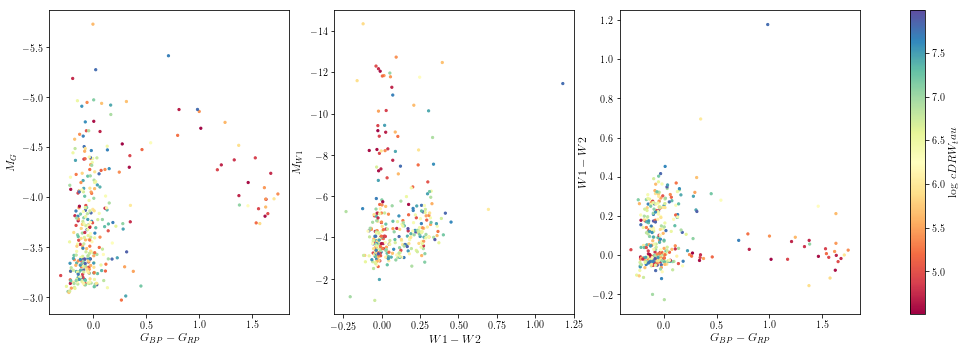

In [67]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='cDRW_tau', cfunc=np.log, points='scatter', s=5, cmap='Spectral')

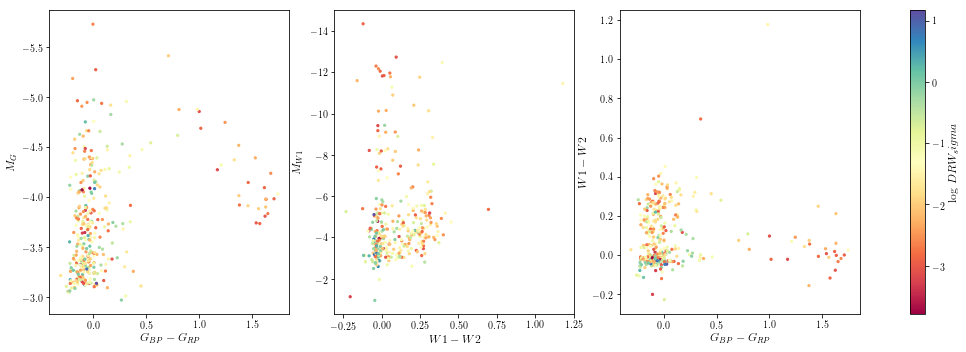

In [64]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='DRW_sigma', cfunc=np.log, points='scatter', s=5, cmap='Spectral')

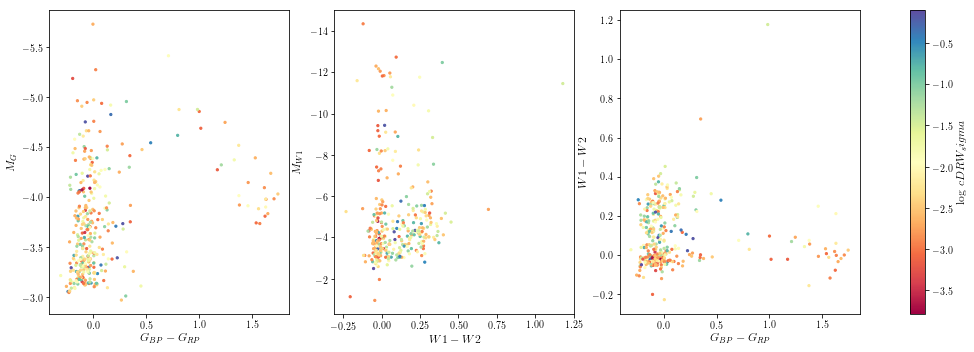

In [69]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='cDRW_sigma', cfunc=np.log, points='scatter', s=5, cmap='Spectral')

In [65]:
def sign_log_abs(x):
    __name__ = 'Sign Log Abs'
    return np.sign(x)*np.log(np.abs(x))

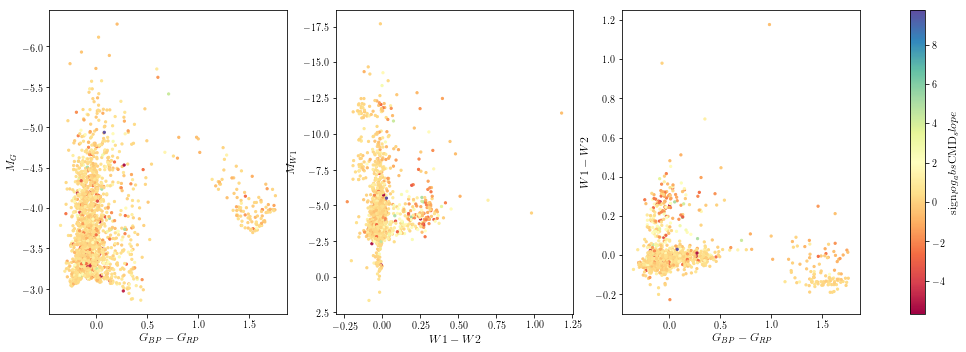

In [70]:
fig, optax, irax, colax, cbar = plot_3_plots(bright, col='CMD_slope', cfunc=sign_log_abs, points='scatter', s=5, cmap='Spectral')

# Ok let's dive into this

(array([15.33596838,  1.58102767,  0.4743083 ,  0.31620553,  0.31620553,
         0.        ,  0.        ,  0.        ,  0.        ,  0.15810277]),
 array([0.032, 0.087, 0.142, 0.197, 0.252, 0.307, 0.362, 0.417, 0.472,
        0.527, 0.582]),
 <a list of 1 Patch objects>)

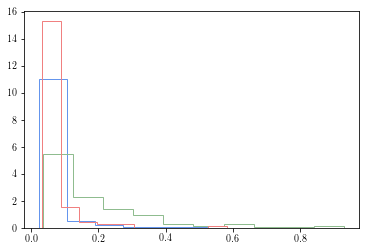

In [74]:
plt.hist(np.log10(mainsequence['Amplitude'].dropna()),histtype='step',color='cornflowerblue',density=True)
plt.hist(np.log10(dustyms['Amplitude'].dropna()),histtype='step',color='darkseagreen',density=True)
plt.hist(postms['Amplitude'].dropna(),histtype='step',color='lightcoral',density=True)

In [82]:
def plot_hists(dfs, column, cfunc=None, colors=None, labels=None, *args, **kwargs):
    """
    Make a histogram of the values in column from the dfs in dfs.
    
    Parameters
    ----------
    dfs : list-like
        DataFrames to make histograms of
    column : str
        Column to color by
    cfunc : Function, optional
        Function to apply to column of dataframe first
    colors : list of str, optional
        List of colors for histogram lines. If given, must be same len as dfs
    labels : list of str, optional
        List of labels for histogram lines. If given must be same len as dfs
    *args, **kwargs
        Passed to matplotlib.pyplot.histogram
    """
    
    fig = plt.figure()
    
    if colors is not None:
        assert len(colors) == len(dfs)
    if labels is not None:
        assert len(labels) == len(dfs)
    if cfunc is not None:
        xlabel = '{0} ${1}$'.format(cfunc.__name__,column)
    else:
        xlabel = '${0}$'.format(column)
    
    for i, df in enumerate(dfs):
        
        if cfunc is not None:
            values = cfunc(df[column].dropna())
        else:
            values = df[column].dropna()
            
        if labels is not None:
            label = labels[i]
        else:
            label = None
        
        if colors is not None:
            color = colors[i]
        else:
            color=None
            
        plt.hist(values,color=color,label=label,*args,**kwargs)
    plt.xlabel(xlabel)
    plt.ylabel('$N$')
    if labels is not None:
        plt.legend()
    
    return fig

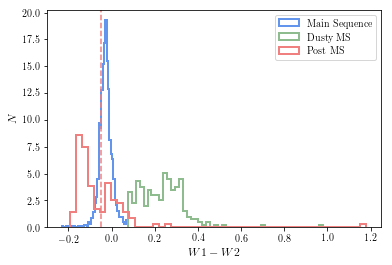

In [110]:
fig = plot_hists([mainsequence,dustyms,postms],'W1-W2',cfunc=None,
                 colors=['cornflowerblue','darkseagreen','lightcoral'],
                 labels=['Main Sequence','Dusty MS','Post MS'],
                 histtype='step',density=True,bins=50,lw=2)
plt.axvline(x=-0.05,ls='--',c='lightcoral')

In [112]:
postms_blue = postms[(postms['W1-W2']<-0.05)]
postms_red = postms[(postms['W1-W2']>=-0.05)]

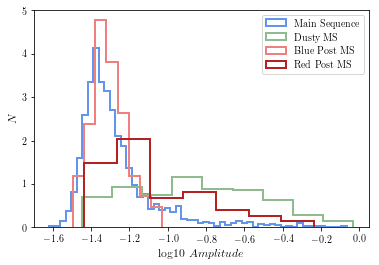

In [113]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'Amplitude',cfunc=np.log10,
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)

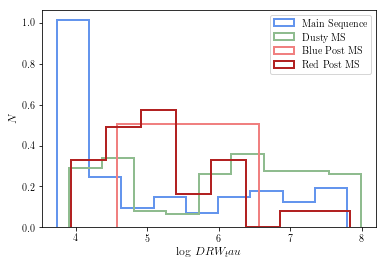

In [116]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'DRW_tau',cfunc=np.log,
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)

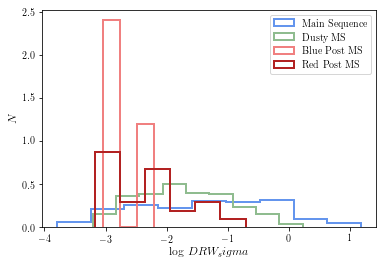

In [117]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'DRW_sigma',cfunc=np.log,
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)

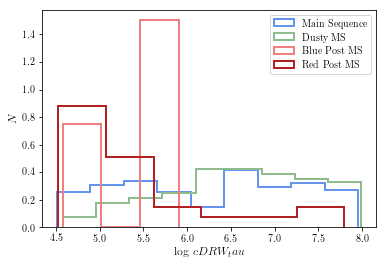

In [118]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'cDRW_tau',cfunc=np.log,
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)

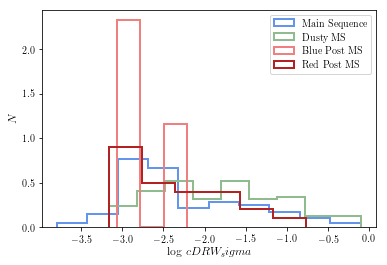

In [119]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'cDRW_sigma',cfunc=np.log,
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)

(-5, 5)

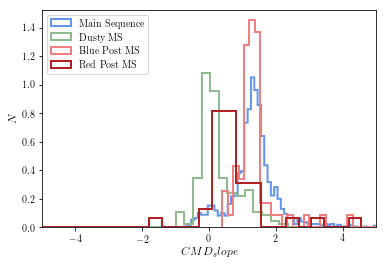

In [121]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'CMD_slope',
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)
plt.xlim(-5,5)

(-1, 1)

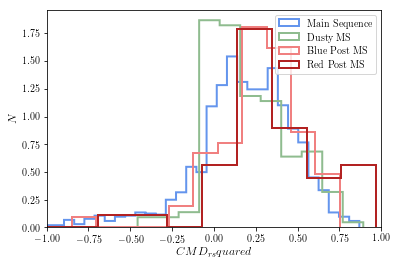

In [123]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'CMD_r_squared',
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)
plt.xlim(-1,1)

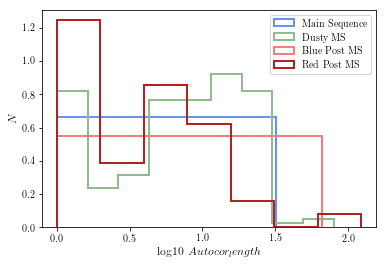

In [125]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'Autocor_length',cfunc=np.log10,
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)

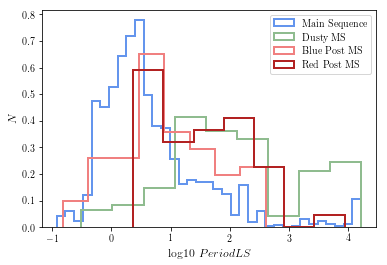

In [126]:
fig = plot_hists([mainsequence,dustyms,postms_blue,postms_red],'PeriodLS',cfunc=np.log10,
                 colors=['cornflowerblue','darkseagreen','lightcoral','firebrick'],
                 labels=['Main Sequence','Dusty MS','Blue Post MS','Red Post MS'],
                 histtype='step',density=True,bins='auto',lw=2)